c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


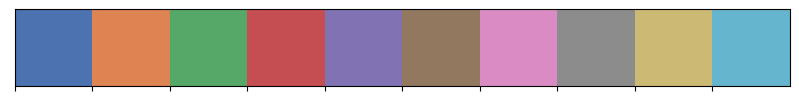

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023May01'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [3]:
results = torch.load(os.path.join(datadir, "summarized_results.pt"))
print(results.keys())
print(results[(0.1,0.5)].keys())

dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0)])
dict_keys(['mean_loss_avg_over_runs_samples', 'std_loss_avg_over_runs_samples', 'loss_avg_over_runs', 'loss_full', 'loss_indices', 'param_true', 'times', 'signals', 'measured_settings', 'measured_values', 'times_finer', 'signals_finer'])


In [4]:
len(results[(0.1,0.5)]['measured_settings'])

20

In [5]:
case_gd = np.hstack(results[(0.1,0.5)]['measured_settings'][0])
case_bayes = np.hstack(results[(0.1,0.5)]['measured_settings'][5])
case_seq = np.hstack(results[(0.1,0.5)]['measured_settings'][10])
case_rdn = np.hstack(results[(0.1,0.5)]['measured_settings'][16])

In [14]:
case_gd.shape

(40, 100)

In [23]:
N_iters = 15
x_cm = torch.arange(N_iters).tile(100)

y_gd = torch.cat(torch.unbind(torch.from_numpy(case_gd[:N_iters]), dim=1))
J_gd = results[(0.1,0.5)]['param_true'][0,:,0].repeat_interleave(N_iters)
D_gd = results[(0.1,0.5)]['param_true'][0,:,1].repeat_interleave(N_iters)

y_bayes = torch.cat(torch.unbind(torch.from_numpy(case_bayes[:N_iters]), dim=1))
J_bayes = results[(0.1,0.5)]['param_true'][5,:,0].repeat_interleave(N_iters)
D_bayes = results[(0.1,0.5)]['param_true'][5,:,1].repeat_interleave(N_iters)

y_rdn = torch.cat(torch.unbind(torch.from_numpy(case_rdn[:N_iters]), dim=1))
J_rdn = results[(0.1,0.5)]['param_true'][0,:,0].repeat_interleave(N_iters)
D_rdn = results[(0.1,0.5)]['param_true'][0,:,1].repeat_interleave(N_iters)

C:\Users\zhant\AppData\Local\Temp\ipykernel_17144\715136517.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


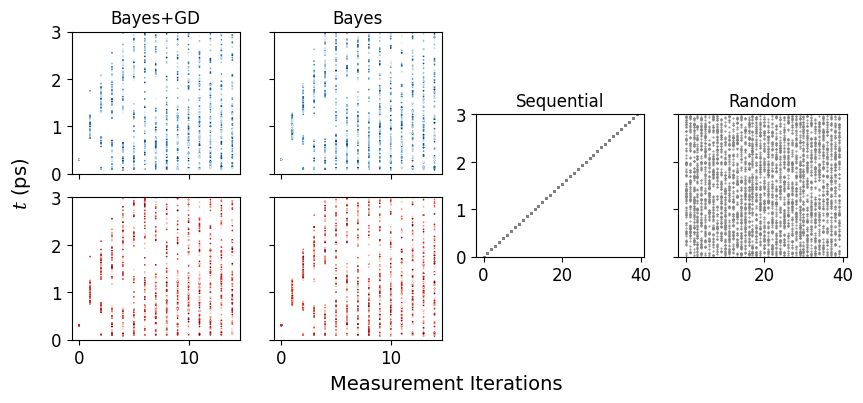

In [29]:
# fig, axes = plt.subplots(2,4,figsize=(10,4),sharex=True,sharey=True,dpi=200)

fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=4, ncols=4, hspace=0.4)

axJ_gd = fig.add_subplot(gs[:2,0])
plt.setp(axJ_gd.get_xticklabels(), visible=False)
axJ_bayes = fig.add_subplot(gs[:2,1], sharey=axJ_gd)
plt.setp(axJ_bayes.get_xticklabels(), visible=False)
plt.setp(axJ_bayes.get_yticklabels(), visible=False)
axJ_seq = fig.add_subplot(gs[1:3,2])
axJ_rdn = fig.add_subplot(gs[1:3,3], sharey=axJ_seq)
plt.setp(axJ_rdn.get_yticklabels(), visible=False)
axD_gd = fig.add_subplot(gs[2:,0])
axD_bayes = fig.add_subplot(gs[2:,1], sharey=axD_gd)
plt.setp(axD_bayes.get_yticklabels(), visible=False)
# axD_seq = fig.add_subplot(gs[2:,2])
# axD_rdn = fig.add_subplot(gs[2:,3])

axJ_gd.scatter(x_cm, y_gd, s=1.5, c=J_gd, cmap='Blues', linewidths=0)
# axJ_gd.vlines([14.5], 0, 3, linewidth=0.35, color='k')
axJ_bayes.scatter(x_cm, y_bayes, s=1.5, c=J_bayes, cmap='Blues', linewidths=0)
axJ_seq.plot(case_seq, 'o', markersize=.5, color='gray')
axJ_rdn.plot(case_rdn, 'o', markersize=.5, color='gray')

axD_gd.scatter(x_cm, y_gd, s=1.5, c=D_gd, cmap='Reds', linewidths=0)
# axD_gd.vlines([14.5], 0, 3, linewidth=0.35, color='k')
axD_bayes.scatter(x_cm, y_bayes, s=1.5, c=D_bayes, cmap='Reds', linewidths=0)
# axD_seq.plot(case_seq, 'o', markersize=.5, color='gray')
# axD_rdn.plot(case_rdn, 'o', markersize=.5, color='gray');

for _ax in [axJ_gd, axD_gd, axJ_seq, axJ_rdn]:
    _ax.set_ylim([0,3])

axJ_gd.set_title('Bayes+GD')
axJ_bayes.set_title('Bayes')
axJ_seq.set_title('Sequential')
axJ_rdn.set_title('Random')

fig.text(0.5,0.0, "Measurement Iterations", ha="center", va="center", fontdict={'size': 14})
fig.text(0.075,0.5, "$t$ (ps)", ha="center", va="center", rotation=90, fontdict={'size': 14})

fig.tight_layout()
fig.savefig('figures/settings_visualization_zoomed_in.pdf', bbox_inches='tight')

In [31]:
N_iters = 40
x_cm = torch.arange(N_iters).tile(100)

y_gd = torch.cat(torch.unbind(torch.from_numpy(case_gd[:N_iters]), dim=1))
J_gd = results[(0.1,0.5)]['param_true'][0,:,0].repeat_interleave(N_iters)
D_gd = results[(0.1,0.5)]['param_true'][0,:,1].repeat_interleave(N_iters)

y_bayes = torch.cat(torch.unbind(torch.from_numpy(case_bayes[:N_iters]), dim=1))
J_bayes = results[(0.1,0.5)]['param_true'][5,:,0].repeat_interleave(N_iters)
D_bayes = results[(0.1,0.5)]['param_true'][5,:,1].repeat_interleave(N_iters)

y_rdn = torch.cat(torch.unbind(torch.from_numpy(case_rdn[:N_iters]), dim=1))
J_rdn = results[(0.1,0.5)]['param_true'][0,:,0].repeat_interleave(N_iters)
D_rdn = results[(0.1,0.5)]['param_true'][0,:,1].repeat_interleave(N_iters)

C:\Users\zhant\AppData\Local\Temp\ipykernel_17144\1780202648.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


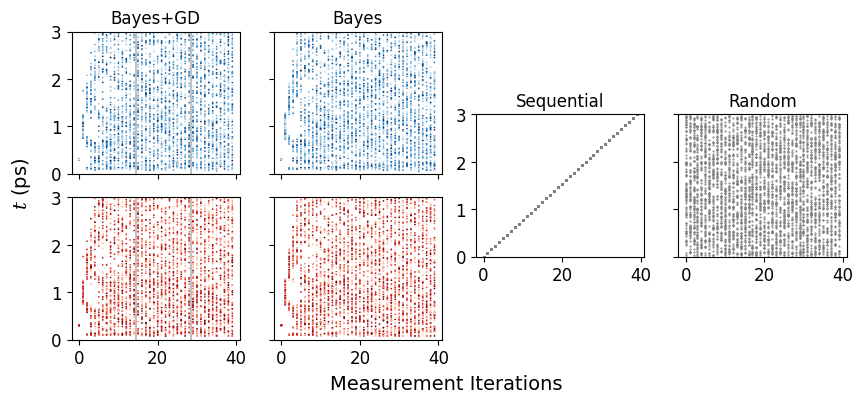

In [32]:
# fig, axes = plt.subplots(2,4,figsize=(10,4),sharex=True,sharey=True,dpi=200)

fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=4, ncols=4, hspace=0.4)

axJ_gd = fig.add_subplot(gs[:2,0])
plt.setp(axJ_gd.get_xticklabels(), visible=False)
axJ_bayes = fig.add_subplot(gs[:2,1], sharey=axJ_gd)
plt.setp(axJ_bayes.get_xticklabels(), visible=False)
plt.setp(axJ_bayes.get_yticklabels(), visible=False)
axJ_seq = fig.add_subplot(gs[1:3,2])
axJ_rdn = fig.add_subplot(gs[1:3,3], sharey=axJ_seq)
plt.setp(axJ_rdn.get_yticklabels(), visible=False)
axD_gd = fig.add_subplot(gs[2:,0])
axD_bayes = fig.add_subplot(gs[2:,1], sharey=axD_gd)
plt.setp(axD_bayes.get_yticklabels(), visible=False)
# axD_seq = fig.add_subplot(gs[2:,2])
# axD_rdn = fig.add_subplot(gs[2:,3])

axJ_gd.scatter(x_cm, y_gd, s=1.5, c=J_gd, cmap='Blues', linewidths=0)
axJ_gd.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')
axJ_bayes.scatter(x_cm, y_bayes, s=1.5, c=J_bayes, cmap='Blues', linewidths=0)
axJ_seq.plot(case_seq, 'o', markersize=.5, color='gray')
axJ_rdn.plot(case_rdn, 'o', markersize=.5, color='gray')

axD_gd.scatter(x_cm, y_gd, s=1.5, c=D_gd, cmap='Reds', linewidths=0)
axD_gd.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')
axD_bayes.scatter(x_cm, y_bayes, s=1.5, c=D_bayes, cmap='Reds', linewidths=0)
# axD_seq.plot(case_seq, 'o', markersize=.5, color='gray')
# axD_rdn.plot(case_rdn, 'o', markersize=.5, color='gray');

for _ax in [axJ_gd, axD_gd, axJ_seq, axJ_rdn]:
    _ax.set_ylim([0,3])

axJ_gd.set_title('Bayes+GD')
axJ_bayes.set_title('Bayes')
axJ_seq.set_title('Sequential')
axJ_rdn.set_title('Random')

fig.text(0.5,0.0, "Measurement Iterations", ha="center", va="center", fontdict={'size': 14})
fig.text(0.075,0.5, "$t$ (ps)", ha="center", va="center", rotation=90, fontdict={'size': 14})

fig.tight_layout()
fig.savefig('figures/settings_visualization.pdf', bbox_inches='tight')

C:\Users\zhant\AppData\Local\Temp\ipykernel_15616\3376898472.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


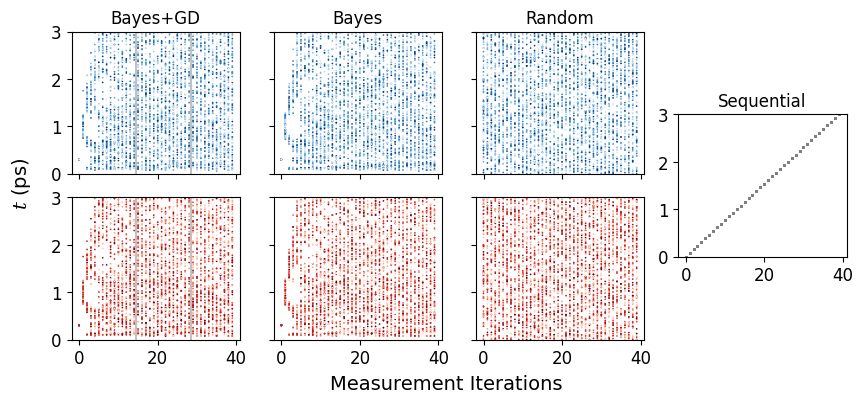

In [16]:
# fig, axes = plt.subplots(2,4,figsize=(10,4),sharex=True,sharey=True,dpi=200)

fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=4, ncols=4, hspace=0.4)

axJ_gd = fig.add_subplot(gs[:2,0])
plt.setp(axJ_gd.get_xticklabels(), visible=False)
axJ_bayes = fig.add_subplot(gs[:2,1], sharey=axJ_gd)
plt.setp(axJ_bayes.get_xticklabels(), visible=False)
plt.setp(axJ_bayes.get_yticklabels(), visible=False)
axJ_seq = fig.add_subplot(gs[1:3,3])
axJ_rdn = fig.add_subplot(gs[:2,2], sharey=axJ_gd)
plt.setp(axJ_rdn.get_yticklabels(), visible=False)
axD_gd = fig.add_subplot(gs[2:,0])
axD_bayes = fig.add_subplot(gs[2:,1], sharey=axD_gd)
plt.setp(axD_bayes.get_yticklabels(), visible=False)
axD_rdn = fig.add_subplot(gs[2:,2], sharey=axJ_gd)
plt.setp(axJ_rdn.get_xticklabels(), visible=False)
plt.setp(axJ_rdn.get_yticklabels(), visible=False)
plt.setp(axD_rdn.get_yticklabels(), visible=False)
# axD_seq = fig.add_subplot(gs[2:,2])
# axD_rdn = fig.add_subplot(gs[2:,3])

axJ_gd.scatter(x_cm, y_gd, s=1.5, c=J_gd, cmap='Blues', linewidths=0)
axJ_gd.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')
axJ_bayes.scatter(x_cm, y_bayes, s=1.5, c=J_bayes, cmap='Blues', linewidths=0)
axJ_seq.plot(case_seq, 'o', markersize=.5, color='gray')

axJ_rdn.scatter(x_cm, y_rdn, s=1.5, c=J_rdn, cmap='Blues', linewidths=0)
axD_rdn.scatter(x_cm, y_rdn, s=1.5, c=D_rdn, cmap='Reds', linewidths=0)

axD_gd.scatter(x_cm, y_gd, s=1.5, c=D_gd, cmap='Reds', linewidths=0)
axD_gd.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')
axD_bayes.scatter(x_cm, y_bayes, s=1.5, c=D_bayes, cmap='Reds', linewidths=0)
# axD_seq.plot(case_seq, 'o', markersize=.5, color='gray')
# axD_rdn.plot(case_rdn, 'o', markersize=.5, color='gray');

for _ax in [axJ_gd, axD_gd, axJ_seq, axJ_rdn]:
    _ax.set_ylim([0,3])

axJ_gd.set_title('Bayes+GD')
axJ_bayes.set_title('Bayes')
axJ_seq.set_title('Sequential')
axJ_rdn.set_title('Random')

fig.text(0.5,0.0, "Measurement Iterations", ha="center", va="center", fontdict={'size': 14})
fig.text(0.075,0.5, "$t$ (ps)", ha="center", va="center", rotation=90, fontdict={'size': 14})

fig.tight_layout()
# fig.savefig('figures/settings_visualization.pdf', bbox_inches='tight')

In [93]:
from sklearn.neighbors import KernelDensity

def calculate_p_score(setting_array):
    priority = np.zeros((setting_array.shape[0]-1, 301))
    for i in range(setting_array.shape[0]-1):
        kde_1d = KernelDensity(kernel="exponential", bandwidth="scott").fit(setting_array[i+1,:,None])
        _priority = kde_1d.score_samples(np.linspace(0,3,301)[:,None])
        priority[i] = np.log(np.exp(_priority) / np.exp(_priority).sum())
        # priority[i] = _priority
    p_score = np.sum(np.exp(-1*np.arange(priority.shape[0]))[:,None] * np.exp(priority), axis=0)
    # plt.plot(p_score)
    return p_score

In [102]:
# p_dict = {}
# for _key in results.keys():
#     p_dict[_key] = [np.hstack(results[_key]['measured_settings'][i]) for i in range(5)]
    

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 40 and the array at index 34 has size 39

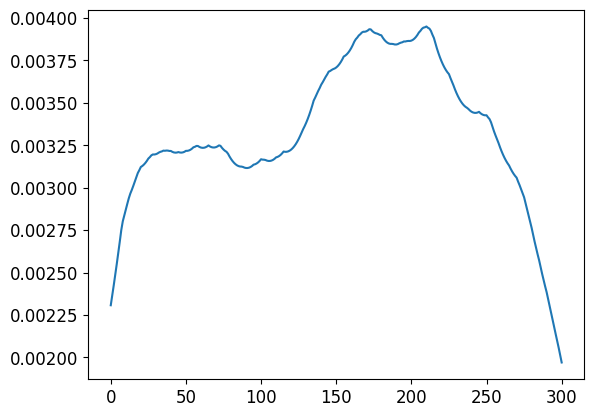

In [84]:
plt.plot(np.exp(priority[i]))

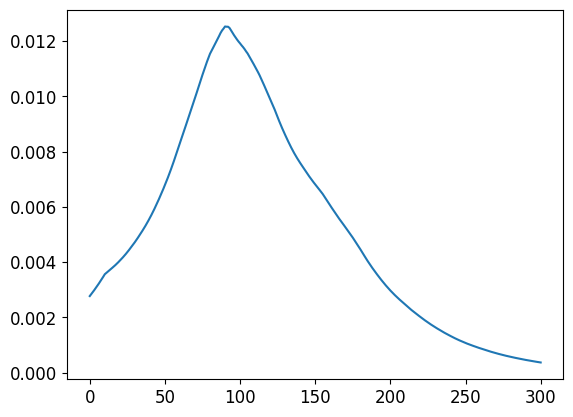

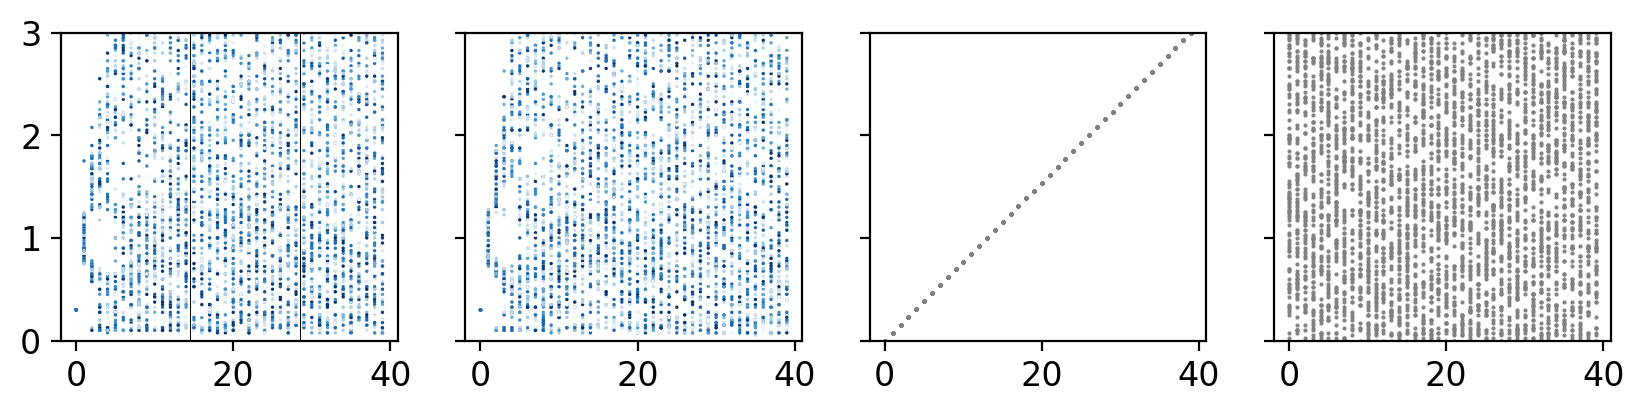

In [87]:
fig, axes = plt.subplots(1,4,figsize=(10,2),sharey=True,dpi=200)
ax_gd = axes[0]
ax_bayes = axes[1]
ax_seq = axes[2]
ax_rdn = axes[3]
# ax_gd.plot(case_gd, 'o', markersize=.5, color='gray')
ax_gd.scatter(x_cm, y_gd, s=1.5, c=D_gd, cmap='Blues', linewidths=0)
ax_gd.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')

ax_bayes.scatter(x_cm, y_bayes, s=1.5, c=D_bayes, cmap='Blues', linewidths=0)
# ax_bayes.plot(case_bayes, 'o', markersize=.5, color='gray')
# ax_bayes.vlines([14.5, 28.5], 0, 3, linewidth=0.35, color='k')
ax_seq.plot(case_seq, 'o', markersize=.5, color='gray')
ax_rdn.plot(case_rdn, 'o', markersize=.5, color='gray');
for _ax in [ax_gd, ax_bayes, ax_seq, ax_rdn]:
    _ax.set_ylim([0,3])